## Wrapper Use Overview

This notebook is intended to provide an overview of how to use Tisean via the modified pytisean wrapper.  This first section provides an overview of how to call Tisean from Python.  The second section shows an example analysis done on Tisean's example amplitude.dat.

To start, the wrapper must be imported.  The wrapper utilizes several other libraries: numpy, os,sys,time,collections/OrderedDict,tempfile, and subprocess. These are loaded with the wrapper.  



In [1]:
from pytiseanWHelperFunctions import *

The wrapper functions by passing numpy arrays into Tisean and reading the result.  There are two ways to do this.  They will be demonstrated with the dummy array x defined below. 

In [2]:
x = np.sin(np.linspace(0,10*np.pi,1000))

The first approach is to call tisean directly using tiseanio.  To do this one inputs the Tisean function to be called as a string followed by its parameters, specifed like '-Param1Here', Param1Value, and then indicating the data to be used.  The parameters must be specified otherwise the call may not work.  

Below Tisean's corr function used to on the previously defined dummy array.   

In [ ]:
# first value (method_1): the output, second value (msg): the tisean function's messages

method_1, msg = tiseanio('corr','-l',len(x),'-x',0,'-c',1,'-D',100,'-V',1,data=x) 

print(method_1[1:10])
print(msg)

The second approach is to use helper functions.  For ease of use helpers have been defined for most of Tiseans functions. They pass Tisean's default values into tiseanio for a user.

When possible, the name of the helper exactly matches the corresponding Tisean function's name. The exceptions are functions with a dash (-) in their name.  In these cases the dash has been replaced with an underscore for python compatability (e.g. ar-model --> ar_model).   

The helper functions only return the output values. The messages are not returned in a variable.

In [ ]:
method_2 = corr(x)

print(method_2[1:10])

The helper functions also contain Tisean's documentation for the functions they call. One can refer to the helper instead of having to look into Tisean's doc directory to find the variable/input definitions and function description. 

In [5]:
help(corr)

Help on function corr in module pytiseanWHelperFunctions:

corr(data, l=-1, x=0, c=1, D=100, n=0, V=1)
    This program computes the autocorrelation of a scalar data set. 
    Depending on whether the -n flag is set or not, different normalizations are applied. With -n not set the definition is:
        
        C(tau) = 1/(N-tau) * (sum_i{(x_i-y)*(x_(i+tau)-y)})/s^2(x)
        
    where s is the standard deviation of the data and y its average.  Else it is
    
        C(tau) = 1/(N-tau)* sum_i{x_i*x_(i+tau)}
    
    Input:
        
        Option  Description                                     Default
        data    Numpy array of data                             N/A
        l       # of data to use                                -1 (whole file)
        x       # of lines to ignore                            0
        c       column to be read                               1
        D       number of correlations                          100
        n       don't use normalizatio

## Example analysis: amplitude.dat

Let's walk through how one might use the wrapper using Tisean's amplitude.dat example. 

In [6]:
amp = np.fromfile('amplitude.dat',sep='\n')

The series looks like this:

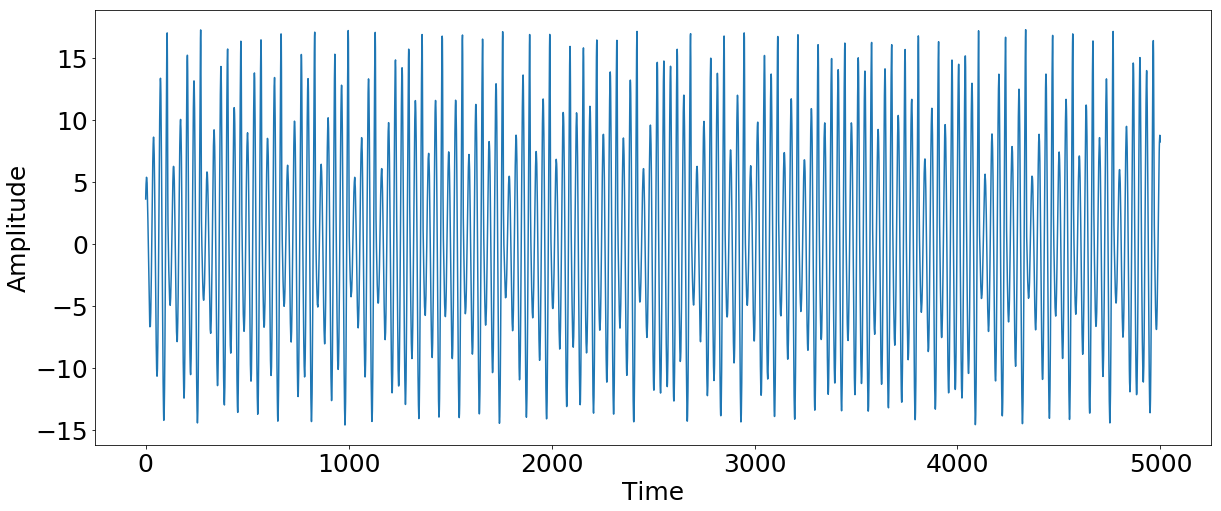

In [7]:
from matplotlib import pyplot as plt
%matplotlib inline

# This changes the default figure size and font.  Adjust as needed to fit your screen.
plt.rcParams.update({'figure.figsize': [20,8], 
                     'font.size': 25})

plt.figure();
plt.plot(amp);
plt.xlabel('Time');
plt.ylabel('Amplitude');

We would like to reconstruct the system's dynamics using delay coordinate embedding.  Two parameters need to be found: the delay ($\tau$) and the embedding dimension ($m$).  We will find them in that order. 

We will select a $\tau$ which minimizes the mutual information.  

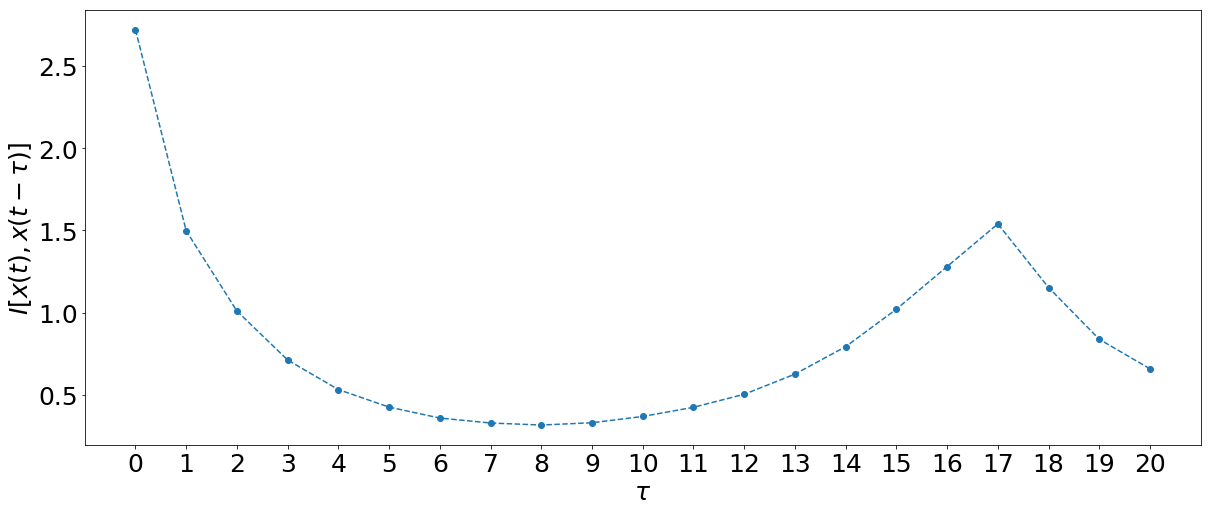

In [8]:
amp_mutual = mutual(amp)


plt.figure()
plt.plot(amp_mutual[:,0],amp_mutual[:,1],marker='o',linestyle='--');
plt.xticks(range(0,21));
plt.xlabel(r'$\tau$');
plt.ylabel(r'$I[x(t),x(t-\tau)]$');

The minimum appears to be at about 8. Note the decrease at about 20 though.  What happens to this as $\tau$ gets larger?

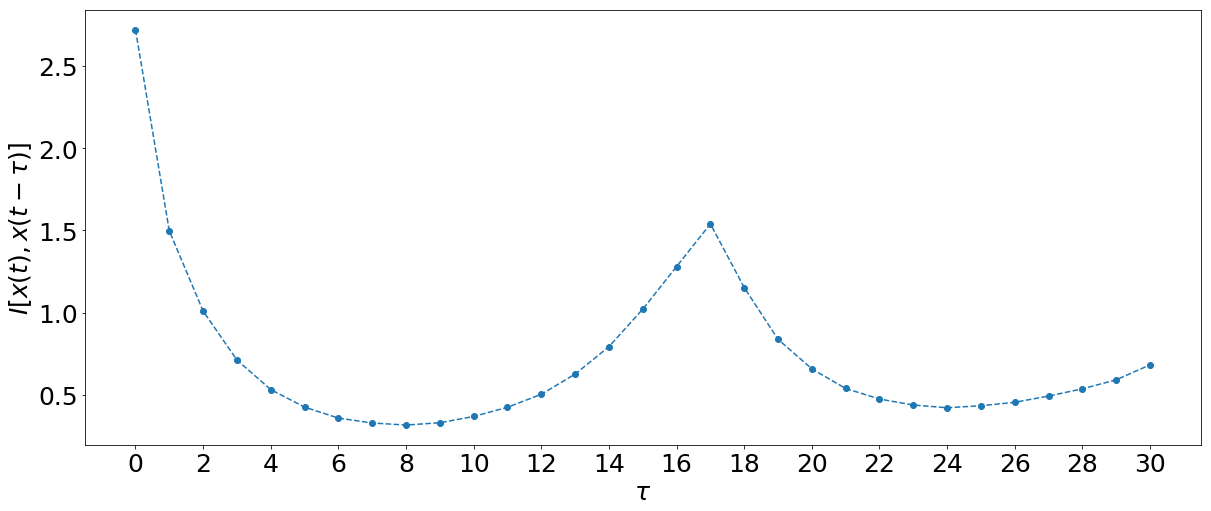

In [9]:
amp_mutual_extended = mutual(amp, D=30) # D indicates the maximum time delay, see help(mutual)


plt.figure()
plt.plot(amp_mutual_extended[:,0],amp_mutual_extended[:,1],marker='o',linestyle='--');
plt.xticks(range(0,31,2));
plt.xlabel(r'$\tau$');
plt.ylabel(r'$I[x(t),x(t-\tau)]$');

Extending the range of $\tau$ we hit another minima.  Other minima can be found if the range is extended further still. This is something one should be aware of.  As a first pass, a good guess is to take the first minima, in this case 8.

Having $\tau$, an embedding dimension, $m$, must now be determined.  This will be estimated by selecting a dimension with a reasonably low percentage of false neighbors. For this quick analysis we will take "reasonably low" to mean less than $\sim30\%$.  In other analyses lower limits (e.g. $<10\%$) are likelydesired.

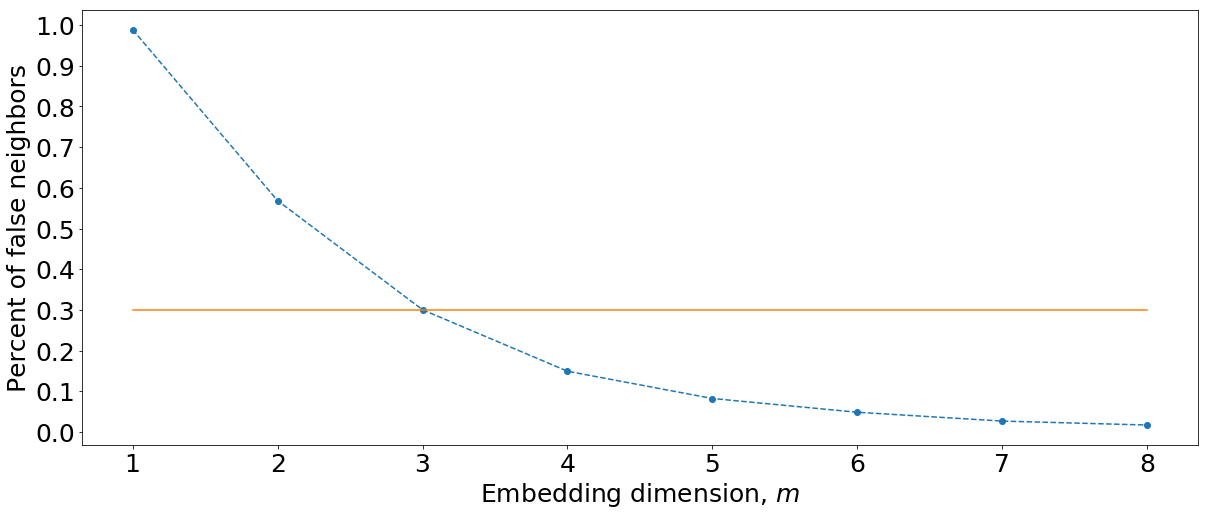

In [10]:
amp_falseNearest = false_nearest(amp, d=8,M='1,8',V=0); #V=0 makes it so that only error messages are shown, see help(false_nearest)

plt.figure()
plt.plot(amp_falseNearest[:,0],amp_falseNearest[:,1],marker='o',linestyle='--');
plt.plot([1,8],[0.3,0.3])
plt.xlabel(r'Embedding dimension, $m$');
plt.ylabel(r'Percent of false neighbors');
plt.yticks([x*0.1 for x in range(0,11)]);

An embedding dimension of 3 is about at our cutoff.  Let's see how it looks.

<IPython.core.display.Javascript object>


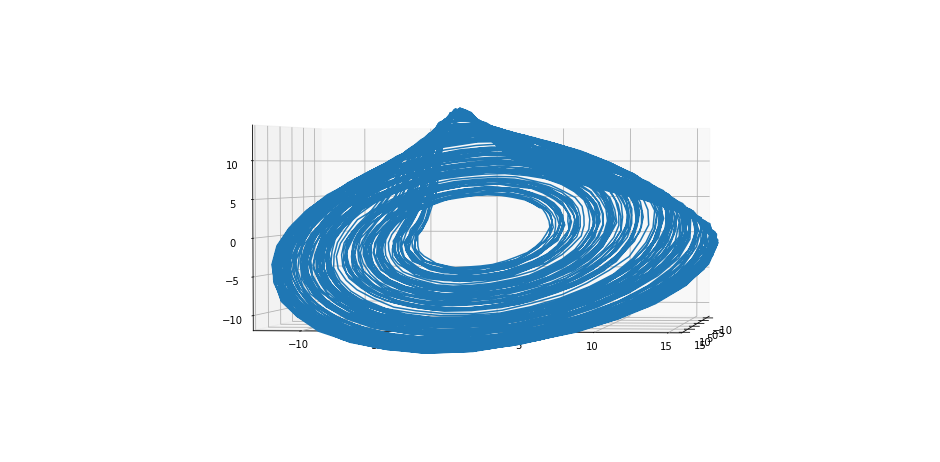

In [12]:
#This cell may need to be rerun to show the visualization.  Once shown it can be freely rotated and resized.

amp_delay = delay(amp,d=8,m=3)

from mpl_toolkits.mplot3d import Axes3D
%matplotlib notebook

fig = plt.figure();
ax =fig.gca(projection='3d');
plt.plot(amp_delay[:,0],amp_delay[:,1],amp_delay[:,2]);

No glaring crossings are found at a quick glance so for demo purposes we will say good enough; we have reconstructed the dynamics of the system.  